# Machine Learning Model


In [1]:
# Importing packages we will be using
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import shap
import mpld3

%store -r X_train X_test y_train y_test df


## Naive Bayes Classifier

**The Naive Bayes classifier** is a simple yet effective probabilistic machine learning algorithm used for classification tasks. It is based on Bayes' theorem and makes the assumption of feature independence, which is where the "naive" in its name comes from.
The Naive Bayes classifier is built on **Bayes Theorem**:
$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$, Where:

$$
P(y|x) = \frac{P(x|y)P(y)}{P(x)}
$$

- $P(x)$: Prior probability of event $x$
- $P(y)$: Prior probability of event $y$
- $P(x|y)$: Probability of event $x$ given event $y$
- $P(y|x)$: Probability of event $y$ given event $x$

Now, let's assume that features are mutually independent (Naive assumption), in our case we get the following equation:
$P(y|\mathbf{X}) = \frac{\prod_{i=1}^{n} P(x_i|y)P(y)}{P(\mathbf{X})}$, where:

- $X$: vector of features $(x_1, x_2, ..., x_n)$
- $x_i$: Individual feature
- $n$: Number of features
- $y$: Event that the person would live in the next 10 years
- $P(X)$: Prior probability of features $X$
- $P(y)$: Prior probability of event $y$
- $P(X|y)$: Probability of features $X$ given event $y$ (LikeHood)
- $P(y|X)$: Probability of event $y$ given features $X$ (Posterior)

Then to select class with highest posterior probability:
$y = \arg\max_y P(y|\mathbf{X}) = \arg\max_y \frac{\prod_{i=1}^{n} P(x_i|y)P(y)}{P(\mathbf{X})}$

Since ${P(X)}$ does not depend on our posterior probability at all we can neglect it.  
$\arg\max_y P(y|\mathbf{X}) = \arg\max_y \left( \prod_{i=1}^{n} P(x_i|y)P(y) \right)$

Since the probabilities calculated by the Naive Bayes classifier are typically between $0$ and $1$, multiplying them together can result in very small numbers. To overcome this issue, a common practice is to apply the logarithm function to transform the multiplication into addition. By taking the logarithm of the probabilities, we can convert the product operation to a summation, which helps avoid numerical underflow. This approach allows for more stable computations and facilitates easier manipulation of probabilities, the formula of this method is given as:  
$y = \arg\max_y \left( \sum_{i=1}^{n} \log(P(x_i|y)) \right) + \log(P(y))$

Finally, We need to calculate the following:

- $P(y)$: Prior probability $\rightarrow$ Frequency of each class
- $P(x_i|y)$: Class conditional probability $\rightarrow$ Model with Gaussian

We will calculate them using the following formula:
$P(x_{i}\mid y) = \frac{1}{\sqrt{2\pi \sigma_y^{2}}} \exp \left(-\frac{(x_{i} -\mu_{y})^2}{2\sigma_y^{2}} \right)$


### Naive Bayes Classifier from Scratch


In [2]:
# First, let's create our Naive Bayes Classifier from scratch
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)  # 0 or 1
        n_classes = len(self._classes)

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)
        for i, c in enumerate(self._classes):
            X_c = X[y == c]
            # Mean of each feature in each class
            self._mean[i, :] = X_c.mean(axis=0)
            self._var[i, :] = X_c.var(axis=0)
            self._priors[i] = X_c.shape[0] / \
                float(n_samples)  # Probability of each class

    def predict(self, X):
        Z = np.array(X)
        y_pred = [self._predict(x) for x in Z]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []
        for i, c in enumerate(self._classes):  # Calculate posterior for each class
            prior = np.log(self._priors[i])
            posterior = np.sum(np.log(self._pdf(i, x)))  # Gaussian model
            posterior += prior
            posteriors.append(posterior)
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, i, x):
        mean = self._mean[i]
        var = self._var[i]

        numerator = np.exp(-(((x - mean) ** 2) / (2 * var)))
        doneminator = np.sqrt(2 * np.pi * var)
        return numerator / doneminator


In [3]:
# Let's create a function to calculate the accuracy of our NB Classifier
def accuracy(a, b):
    return np.sum(a == b) / len(a)


# Now, let's try our NB Classifier
NB_scratch = NaiveBayes()
NB_scratch.fit(X_train, y_train)
y_pred = NB_scratch.predict(X_test)

# Let's check our model's accuracy
print(f"Naive Bayes accuracy: {accuracy(y_test, y_pred)}")


Naive Bayes accuracy: 0.7780872794800371


### Built-in Naive Bayes Classifier


Accuracy score for GaussianNB is 0.7780872794800371


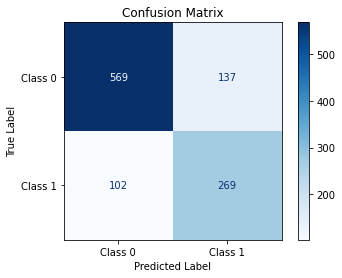

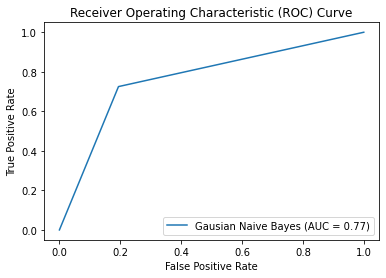

In [4]:
# Let's train our model using Naive Bayes Classifier
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_pred = NB.predict(X_test)
print(f"Accuracy score for GaussianNB is {accuracy_score(y_test, NB_pred)}")

# Let's plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, NB_pred), display_labels=['Class 0', 'Class 1'])

disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Let's plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, NB_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(
    y_test, NB_pred), estimator_name='Gausian Naive Bayes')
roc_display.plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


## Adaboost Classifier

**AdaBoost (Adaptive Boosting)** is a machine learning algorithm used for classification tasks. It combines multiple "weak" classifiers, such as decision stumps, into a single "strong" classifier. Initially, all training examples are assigned equal weights. Weak classifiers are trained sequentially, with weights adjusted to focus on misclassified examples. The final classifier is formed by combining the weak classifiers based on their performance, with more accurate classifiers having higher weights. To classify new instances, the weak classifiers' predictions are combined using their assigned weights. AdaBoost leverages the concept of boosting to iteratively improve its classification accuracy by emphasizing challenging examples. This is how AdaBoost works briefly:

1. Initialization: Each training example, denoted as $(x_i, y_i)$ where $x_i$ is the input features and $y_i$ is the corresponding class label, is assigned an initial weight, $w_i = \frac{1}{n}$, where n is the total number of training examples.
2. Training Weak Classifiers: AdaBoost sequentially trains a series of weak classifiers. Each weak classifier, denoted as $h_t(x)$, is trained on the weighted training data, where the weights represent the importance of each example. The weak classifier aims to minimize the weighted error rate, $Err_t$, defined as the sum of weights of misclassified examples:
   $Err_t = Σ_i(w_i * I(y_i ≠ h_t(x_i)))$
3. Weight Update: Once the weak classifier is trained, its weight, α_t, is calculated based on its performance: $α_t = 0.5 * ln((1 - Err_t) / Err_t)$. The weight $α_t$ measures the contribution of the weak classifier in the final classification. Higher values of $α_t$ are assigned to more accurate classifiers, while lower values are assigned to weaker ones. The weights of the training examples are updated as follows: $w_i ← w_i * exp(-α_t * y_i * h_t(x_i))$. This update increases the weights of the misclassified examples, making them more important for subsequent classifiers to focus on.
4. Combining Classifiers: The final classification is determined by combining the weak classifiers' predictions using their weights. Given a new instance x, the AdaBoost classifier output, H(x), is calculated as: $H(x) = sign(Σ_t(α_t * h_t(x)))$. Here, $sign()$ returns the sign of the sum, indicating the predicted class label ($+1$ or $-1$).


In [5]:
# Let's build our classifier
ada_classifier = AdaBoostClassifier()
param_grid = {
    'n_estimators': [30, 31, 32, 33, 34, 35],  # Number of base estimators
    'learning_rate': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Learning rate
}
random_search = RandomizedSearchCV(
    ada_classifier, param_distributions=param_grid, n_iter=10, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


Best Hyperparameters: {'n_estimators': 30, 'learning_rate': 0.5}
Best Score: 0.7986984324599626


## Random Forest Classifier Model

**The Random Forest classifier** is a popular machine learning algorithm used for classification tasks. It belongs to the ensemble learning family and combines the predictions of multiple decision trees to make accurate predictions. Here's a brief explanation of how Random Forest works:

1. Random Subsampling: The algorithm starts by creating an ensemble of decision trees. Each tree is trained on a random subset of the training data, sampled with replacement (known as bootstrap aggregating or "bagging"). This creates diverse subsets of data for each tree.
2. Feature Randomness: During the construction of each decision tree, a random subset of features is considered for splitting at each node. This introduces further randomness and helps to reduce correlation among the trees.
3. Decision Tree Construction: Each decision tree is constructed by recursively partitioning the data based on the selected features. The splitting is done based on criteria such as Gini impurity or information gain, aiming to create nodes that best separate the classes.
4. Voting for Classification: Once all the trees are built, to classify a new instance, each tree independently predicts the class label. The final prediction is made by majority voting, where the class that receives the most votes across all trees is chosen as the final predicted class.


### RF Classifier

In [6]:
# Let's build our model
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_y_pred))


Accuracy: 0.8124419684308264


### Features Impact on RF Model's Prediction


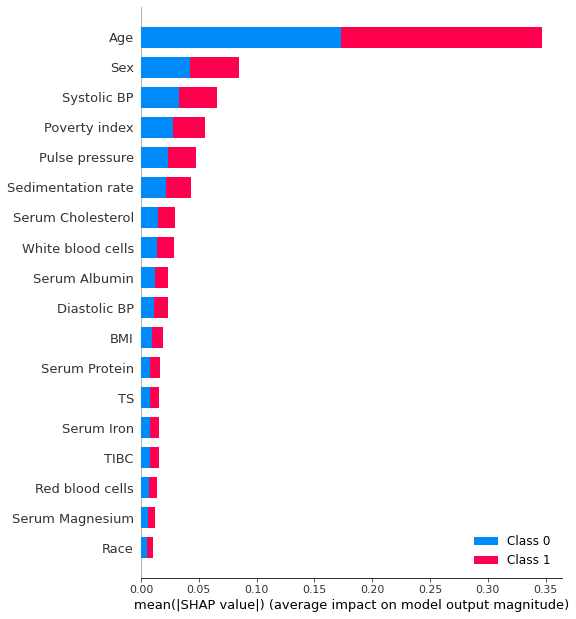

In [10]:
# We will use Shaply to explain how each feature impacts on the prediction of the RF model

# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_classifier)
# Generate SHAP values
shap_values = explainer.shap_values(X_test)
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)


### Visualizing the Tree Ensembles


Interactive decision tree saved as: decision_tree.html


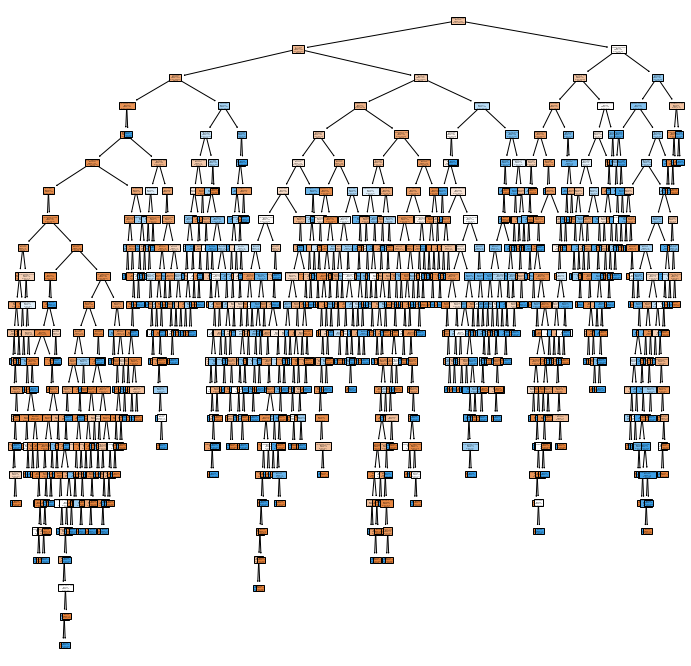

In [8]:
# We will plot the tree ensembles of our RF model

fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(rf_classifier.estimators_[0], feature_names=list(df.columns)[
          :-1], class_names=list(df.columns)[-1], filled=True, ax=ax)

output_file = 'decision_tree.html'
mpld3.save_html(fig, output_file)
print(f"Interactive decision tree saved as: {output_file}")


## Using an Ensemble of Models for Better Performance

Now, we will use several different classifiers (MLP Classifier, Logistic Regression, SVC, RF Classifier), and use a voting classifier to detect the best accuracy among all these different classifiers.


In [9]:
# We will perform a standard scalar to our training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize individual classifiers
classifier_1 = RandomForestClassifier(random_state=42)
classifier_2 = LogisticRegression(random_state=42)
classifier_3 = SVC(random_state=42, probability=True)
classifier_4 = MLPClassifier(solver='adam', alpha=1e-4,
                             hidden_layer_sizes=(5, 2), random_state=1, max_iter=500)

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('rf', classifier_1), ('lr', classifier_2),
                ('svm', classifier_3), ("MLP", classifier_4)],
    voting='soft'
)

# Train the Voting Classifier
voting_classifier.fit(X_train_scaled, y_train)

y_pred = voting_classifier.predict(X_test_scaled)

# Evaluate the Voting Classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8115134633240483
